### Exploring and Transforming BART data

- We take 10 busiest trips
- We don't take 2020.
- Data has 10 years.

In [2]:
import gzip
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
in_path = Path("../data/BART/ridership/http:/64.111.127.166/origin-destination")

In [4]:
list(in_path.iterdir())

[PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2020.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2016.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2018.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2014.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2012.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2017.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2019.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2015.csv.gz'),
 PosixPath('../data/BART/ridership/http:/64.111.127.166/origin-destination/date-hour-soo-dest-2011.csv.gz'),
 PosixPath('../data

In [5]:
all_sums = []
for path in in_path.iterdir():
    with open(path) as fp:
        df = pd.read_csv(fp)
        df['trip'] = df['Origin Station'] + "_" + df['Destination Station']
        all_sums.append(
            df.groupby('trip')['Trip Count'].sum().copy()
        )

In [6]:
busiest_trips = pd.concat(all_sums).groupby('trip').sum().reset_index().sort_values('Trip Count', ascending=False).iloc[:10]['trip'].tolist()

In [7]:
from tqdm import tqdm

In [8]:
all_dfs = []
for path in tqdm(in_path.iterdir()):
    with open(path) as fp:
        df = pd.read_csv(fp)
        df['trip'] = df['Origin Station'] + "_" + df['Destination Station']
        all_dfs.append(
            df[df['trip'].isin(busiest_trips)].copy()
        )

10it [01:07,  6.74s/it]


In [9]:
df = pd.concat(all_dfs)
df['dt'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], "H")
df = df.set_index('dt')[['trip', 'Trip Count']]

In [11]:
HRS_IN_9_YRS = 9 * 52 * 7 * 24
print(HRS_IN_9_YRS)

78624


POWL_BALB, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
BALB_MONT, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
BALB_POWL, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
POWL_24TH, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
24TH_MONT, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
DUBL_EMBR, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
24TH_POWL, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
POWL_16TH, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
WOAK_EMBR, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624
MONT_24TH, 2011-01-12 00:00:00, 2019-12-31 23:00:00, 78624


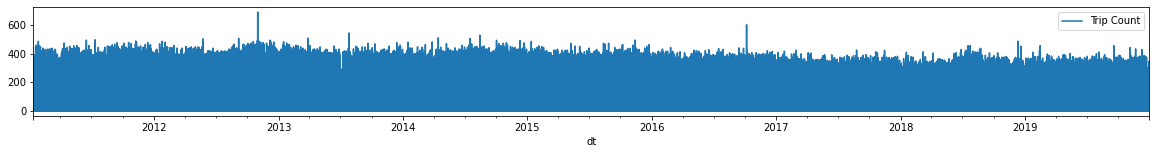

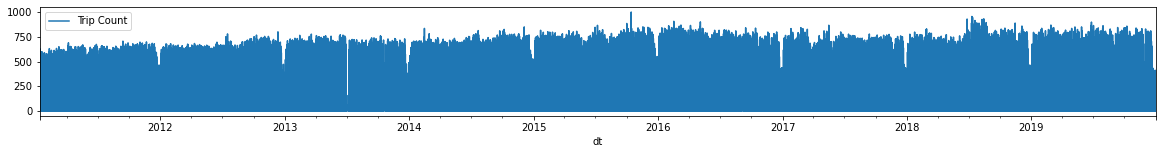

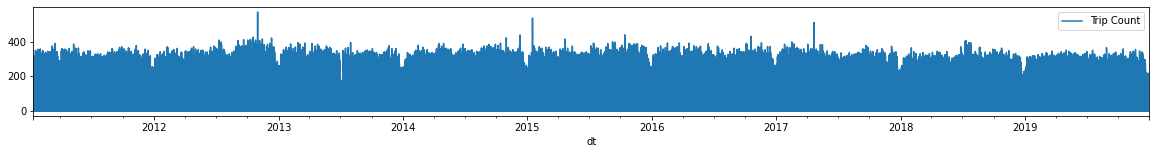

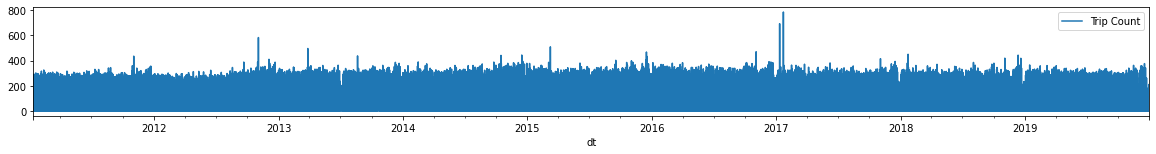

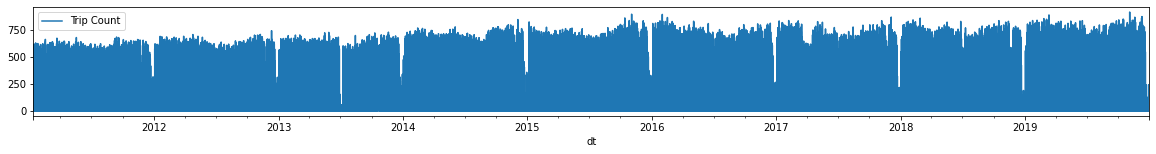

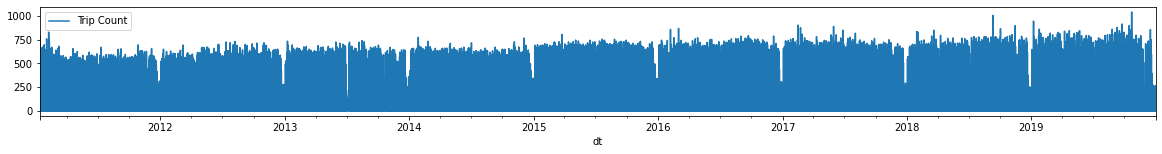

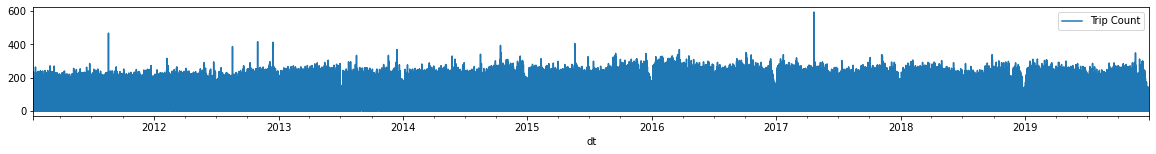

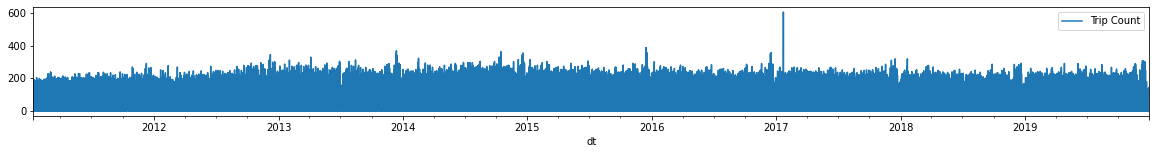

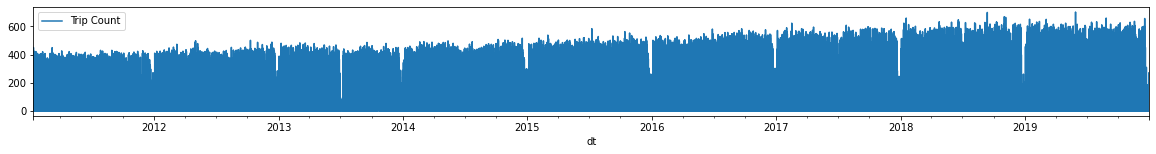

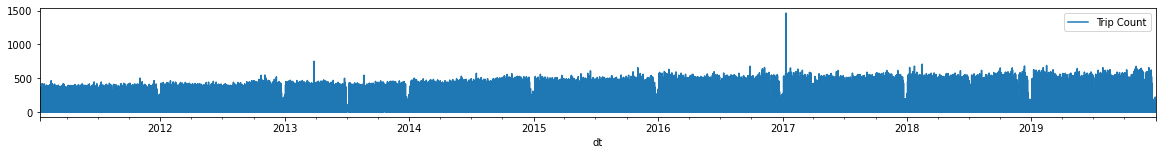

In [12]:
objs = []
for bt in busiest_trips:
    tdf = df[(df['trip'] == bt) & (df.index < '2020-01-01 00:00:00')]  # don't let COVID in
    resampled = tdf.resample(rule="1H").sum()[-HRS_IN_9_YRS:]
    
    # plot
    f, ax = plt.subplots(figsize=(20, 2))
    resampled.plot(ax=ax)
    
    print(f"{bt}, {resampled.index[0]}, {resampled.index[-1]}, {len(resampled.index)}")
    
    objs.append({
        "target": resampled['Trip Count'].tolist(),
        "start": str(resampled.index[0]),
        "freq": "1H",
        "id": bt,
    })

In [13]:
import json
out_path = Path("../datasets/kaggle_bart/")

for o in objs:
    with open(out_path / f"{o['id']}.json", "w") as fp:
        json.dump(o, fp)